# Project 1: Cyclic Coordinate Descent for Regularized Logistic Regression

## Datasets

dataset1

dataset2

dataset3

dataset4

dataset_synthetic

### Algorithm

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import (
    precision_score, recall_score, f1_score, balanced_accuracy_score,
    roc_auc_score, average_precision_score, accuracy_score
)
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
import warnings
from sklearn.model_selection import train_test_split
warnings.filterwarnings("ignore")

In [2]:
class LogRegCCD(): 
    """
    **DESCRIPTION**
    """
    def __init__(self, scaler=StandardScaler(), seed=42,): 
        self.optimized = False
        self.scaler = scaler
        self.seed = seed


    def __sigmoid(self, x): 
            return 1 / (1 + np.exp(-x))
    
    def __standarize(self, X, standarize=True):  
        return pd.DataFrame(self.scaler.fit_transform(X)) if standarize else X
        
        

    def single_fit(self, X_train, y_train, lambda_=0.01, nr_iter=100, standarize=True, tol=1e-3): 
        def compute_cost(X_train, y_train, lambda_):
            n = len(y_train)
            y_dash = X_train @ self.beta + self.beta_zero
            p = self.__sigmoid(y_dash)
            cost = - (1/n) * np.sum(y_train * np.log(p) + (1 - y_train) * np.log(1 - p))
            reg_term = lambda_ * np.sum(np.abs(self.beta)) / n  # L1 regularization
            return cost + reg_term
        
        def soft_threshold(a, b):
            return np.sign(a) * np.maximum(np.abs(a) - b, 0)
                  
        def calculate_coordinate_descent(X_train, y_train, lambda_, j): 
            y_dash = X_train @ self.beta + self.beta_zero
            p = self.__sigmoid(y_dash)
            p = np.clip(p, 1e-5, 1 - 1e-5)
            w = p * (1 - p)
            z = y_dash + (y_train - p) / w
            # self.beta_zero = np.sum(w * z) / np.sum(w)

            residual = z - y_dash + self.beta[j] * X_train.iloc[:, j]
            st_nom = np.sum(w * X_train.iloc[:, j] * residual)

            st_denom = np.sum(w * X_train.iloc[:, j] ** 2)

            return w, z, soft_threshold(st_nom, lambda_)/st_denom
        
        np.random.seed(self.seed)
        X_train = self.__standarize(X_train, standarize)
        g = X_train.shape[1]
        
        
        self.beta_zero = 0
        self.beta = np.zeros(g)
        self.lambda_ = lambda_


        for i in range(nr_iter): 
            beta_old = self.beta.copy()
            for j in range(g): 
                w, z, beta_j = calculate_coordinate_descent(X_train, y_train, lambda_, j)
                self.beta[j] = beta_j
            self.beta_zero = np.sum(w * z) / np.sum(w)
            # Convergence check
            if np.linalg.norm(self.beta - beta_old, ord=1) < tol:
                break

        self.cost = compute_cost(X_train, y_train, lambda_)
        return self
        
    



    def validate(self, X_valid, y_valid, measure, standarize=True): 
        """
        **DESCRIPTION**

        Parameters
        ----------
        X_valid:

        y_valid:

        measure: 

        Returns
        -------
        

        """
        X_valid = self.__standarize(X_valid, standarize)
        # Get predicted probabilities
        y_prob = self.predict_proba(X_valid, standarize=False)

        # Convert probabilities to binary predictions 
        y_pred = (y_prob >= 0.5).astype(int)

        # Compute the performance measure
        score = measure(y_valid, y_pred)
        return score

    def predict_proba(self, X_test, standarize=True): 
        """
        **DESCRIPTION**

        Parameters
        ----------
        X_test: 

        Returns
        -------
        

        """
        X_test = self.__standarize(X_test, standarize)
        return self.__sigmoid(X_test.dot(self.beta) + self.beta_zero)
        

    def fit(self, X_train, y_train, X_valid=None, y_valid=None, eps=0.001, K=10, measure=accuracy_score, nr_iter=100, standarize=True, tol=1e-3):
        
        X_train = self.__standarize(X_train, standarize)

        if X_valid is None and y_valid is None:
            X_valid = X_train
            y_valid = y_train
        else: 
            X_valid = self.__standarize(X_valid, standarize)

        n = len(y_train)
        # Compute lambda_max = max_l |<x_l, y>| / n (from paper)

        inner_products = np.abs(np.dot(X_train.T, y_train)) / 4
        lambda_max = inner_products.max()
        lambda_min = eps * lambda_max
        
        lambdas = np.exp(np.linspace(np.log(lambda_max), np.log(lambda_min), K))
        # lambdas = np.exp(np.linspace(lambda_max, lambda_min, K))
        
        betas = []
        betas_zero = []
        # costs = []
        scores = []
        
        for lam in lambdas:
            self.single_fit(X_train, y_train, lambda_=lam, nr_iter=nr_iter, standarize=False, tol=tol)
            betas.append(self.beta.tolist())
            betas_zero.append(self.beta_zero)
            # costs.append(self.cost)
            score = self.validate(X_valid, y_valid, measure, standarize=False)
            scores.append(score)
            
        
        p = X_train.shape[1]
        columns = [f"Beta_{i + 1}" for i in range(p)]
        self.coeffs_df = pd.DataFrame(betas, columns=columns)
        self.coeffs_df['Intercept'] = betas_zero
        self.coeffs_df['Lambda'] = lambdas
        # self.coeffs_df['Cost'] = costs
        self.coeffs_df['ValidationScore'] = scores
        
        best_idx = np.argmax(scores)
        self.lambda_ = lambdas[best_idx]
        self.beta = betas[best_idx]
        self.beta_zero = betas_zero[best_idx]
        self.score = scores[best_idx]
        return self

    def plot_coeff(self):
        """
        Plot the coefficient values vs. log(Lambda)
        """
        
        plt.figure(figsize=(10, 6))
        log_lambda = np.log(self.coeffs_df['Lambda'])

        for col in self.coeffs_df.columns:
            if col not in ['Lambda', 'ValidationScore', 'Intercept']:
                plt.plot(log_lambda, self.coeffs_df[col], marker='o', color='blue', linewidth=1)
        
        plt.xlabel("log(Lambda)")
        plt.ylabel("Coefficient Value")
        plt.title("Coefficient values vs. log(Lambda)")
        plt.tight_layout()
        plt.show()

    def plot_score(self):
        """
        Runs fit_optimize_lambda with the provided measure, then plots the validation score vs. log(Lambda).
        """
      
        plt.figure(figsize=(10, 6))
        plt.plot(np.log(self.coeffs_df['Lambda']), self.coeffs_df['ValidationScore'],
                 marker='o', color='blue', linewidth=2)
        plt.xlabel("log(Lambda)")
        plt.ylabel("Validation Score")
        plt.title("Validation Score vs. log(Lambda)\nBest lambda: {:.4f} with score {:.4f}".format(self.lambda_, self.score))
        plt.tight_layout()
        plt.show()
        
        return self.lambda_, self.score



In [4]:
def evaluate_performance(logRegCCD, X, y): 
    # print("Beta: ", logRegCCD.beta)
    # print("Beta zero: ", logRegCCD.beta_zero)

    # print("-----------------")

    print("Accuracy score: ", logRegCCD.validate(X, y, accuracy_score))
    print("Precision score: ", logRegCCD.validate(X, y, precision_score))
    print("Recall score: ", logRegCCD.validate(X, y, recall_score))
    print("F-measure score: ", logRegCCD.validate(X, y, f1_score))
    print("Balanced Accuracy score: ", logRegCCD.validate(X, y, balanced_accuracy_score))
    print("AUC-ROC score: ", logRegCCD.validate(X, y, roc_auc_score))
    print("AUC-PR: score: ", logRegCCD.validate(X, y, average_precision_score))

## dataset1

In [45]:
tecator_data = pd.read_csv("data/tecator.csv", header=None)
tecator_X = tecator_data.iloc[:, :-1]
tecator_y = (tecator_data.iloc[:, -1] == 'P').astype(int)

print(tecator_X.shape)
print("Target distribution (P as 1, N as 0):", sum(tecator_y) / len(tecator_y))
print(tecator_X.head())

tecator_X_train, tecator_X_valid, tecator_y_train, tecator_y_valid = train_test_split(
    tecator_X, tecator_y, test_size=0.2, random_state=42, stratify=tecator_y
)

(240, 124)
Target distribution (P as 1, N as 0): 0.425
       0        1        2        3        4        5        6        7    \
0  2.61776  2.61814  2.61859  2.61912  2.61981  2.62071  2.62186  2.62334   
1  2.83454  2.83871  2.84283  2.84705  2.85138  2.85587  2.86060  2.86566   
2  2.58284  2.58458  2.58629  2.58808  2.58996  2.59192  2.59401  2.59627   
3  2.82286  2.82460  2.82630  2.82814  2.83001  2.83192  2.83392  2.83606   
4  2.78813  2.78989  2.79167  2.79350  2.79538  2.79746  2.79984  2.80254   

       8        9    ...       114       115       116       117       118  \
0  2.62511  2.62722  ...  0.296029  0.233876  0.899661 -0.042006  0.708717   
1  2.87093  2.87661  ... -0.454959 -0.195980 -0.046359 -0.634996 -0.354403   
2  2.59873  2.60131  ...  0.628166  0.795466  0.762246 -1.268580  0.690588   
3  2.83842  2.84097  ...  0.281853  0.616500 -0.388684 -2.068390  1.276160   
4  2.80553  2.80890  ...  0.703580 -1.095540 -1.348450  0.453559  0.402624   

        119  

In [48]:
# lambda = 0
logRegCCD_0 = LogRegCCD()
logRegCCD_0 = logRegCCD_0.single_fit(tecator_X_train, tecator_y_train, lambda_ = 0)
evaluate_performance(logRegCCD_0, tecator_X_valid, tecator_y_valid)


Accuracy score:  0.625
Precision score:  0.5833333333333334
Recall score:  0.35
F-measure score:  0.4375
Balanced Accuracy score:  0.5857142857142856
AUC-ROC score:  0.5857142857142857
AUC-PR: score:  0.47500000000000003


Accuracy score:  0.6875
Precision score:  0.7272727272727273
Recall score:  0.4
F-measure score:  0.5161290322580645
Balanced Accuracy score:  0.6464285714285715
AUC-ROC score:  0.6464285714285715
AUC-PR: score:  0.540909090909091


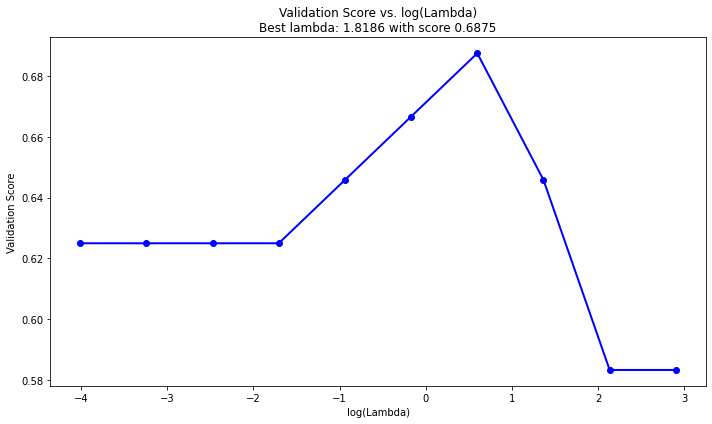

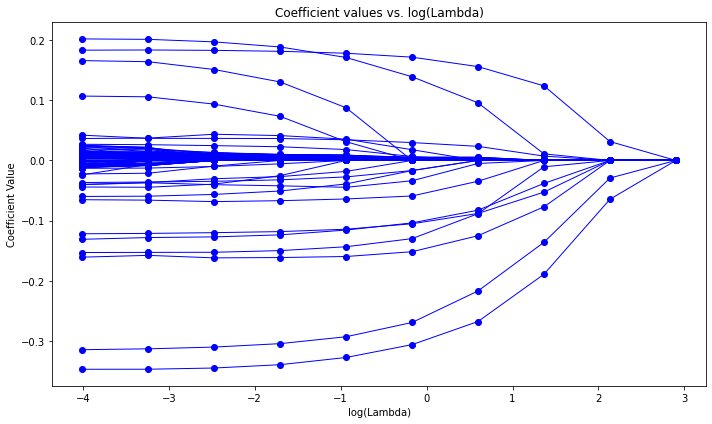

In [54]:
logRegCCD = LogRegCCD()
logRegCCD = logRegCCD.fit(tecator_X_train, tecator_y_train, tecator_X_valid, tecator_y_valid)

evaluate_performance(logRegCCD, tecator_X_valid, tecator_y_valid)
logRegCCD.plot_score()
logRegCCD.plot_coeff()

## dataset2

In [44]:
sonar_data = pd.read_csv("data/sonar.csv", header=None)
sonar_X = sonar_data.iloc[:, :-1]
sonar_y = (sonar_data.iloc[:, -1] == 'Mine').astype(int)

# extended with dummy variables to exceed 50% rule
sonar_X_dummy = sonar_X.copy()
for col in sonar_X_dummy.columns:
    sonar_X_dummy[col] = np.random.permutation(sonar_X_dummy[col])
sonar_X = pd.concat([sonar_X, sonar_X_dummy], axis=1)

print(sonar_X.shape)
print("Target distribution:", sum(sonar_y) / len(sonar_y))
print(sonar_X.head())

sonar_X_train, sonar_X_valid, sonar_y_train, sonar_y_valid = train_test_split(
    sonar_X, sonar_y, test_size=0.2, random_state=42, stratify=sonar_y
)

(208, 120)
Target distribution: 0.5336538461538461
       0       1       2       3       4       5       6       7       8   \
0  0.0200  0.0371  0.0428  0.0207  0.0954  0.0986  0.1539  0.1601  0.3109   
1  0.0453  0.0523  0.0843  0.0689  0.1183  0.2583  0.2156  0.3481  0.3337   
2  0.0262  0.0582  0.1099  0.1083  0.0974  0.2280  0.2431  0.3771  0.5598   
3  0.0100  0.0171  0.0623  0.0205  0.0205  0.0368  0.1098  0.1276  0.0598   
4  0.0762  0.0666  0.0481  0.0394  0.0590  0.0649  0.1209  0.2467  0.3564   

       9   ...      50      51      52      53      54      55      56  \
0  0.2111  ...  0.0137  0.0089  0.0146  0.0135  0.0086  0.0077  0.0016   
1  0.2872  ...  0.0244  0.0083  0.0070  0.0199  0.0063  0.0131  0.0015   
2  0.6194  ...  0.0154  0.0078  0.0189  0.0053  0.0039  0.0151  0.0112   
3  0.1264  ...  0.0208  0.0146  0.0097  0.0077  0.0083  0.0152  0.0126   
4  0.4459  ...  0.0000  0.0090  0.0232  0.0026  0.0075  0.0097  0.0072   

       57      58      59  
0  0.0049  0.

In [45]:
# lambda = 0
logRegCCD_0 = LogRegCCD()
logRegCCD_0 = logRegCCD_0.single_fit(sonar_X_train, sonar_y_train, lambda_ = 0)
evaluate_performance(logRegCCD_0, sonar_X_valid, sonar_y_valid)


Accuracy score:  0.5238095238095238
Precision score:  0.5555555555555556
Recall score:  0.45454545454545453
F-measure score:  0.5
Balanced Accuracy score:  0.5272727272727272
AUC-ROC score:  0.5272727272727272
AUC-PR: score:  0.5382395382395382


In [46]:
logRegCCD = LogRegCCD()
logRegCCD = logRegCCD.fit(sonar_X_train, sonar_y_train, sonar_X_valid, sonar_y_valid)

evaluate_performance(logRegCCD, sonar_X_valid, sonar_y_valid)

Accuracy score:  0.5714285714285714
Precision score:  0.6428571428571429
Recall score:  0.4090909090909091
F-measure score:  0.5000000000000001
Balanced Accuracy score:  0.5795454545454546
AUC-ROC score:  0.5795454545454546
AUC-PR: score:  0.5725108225108225


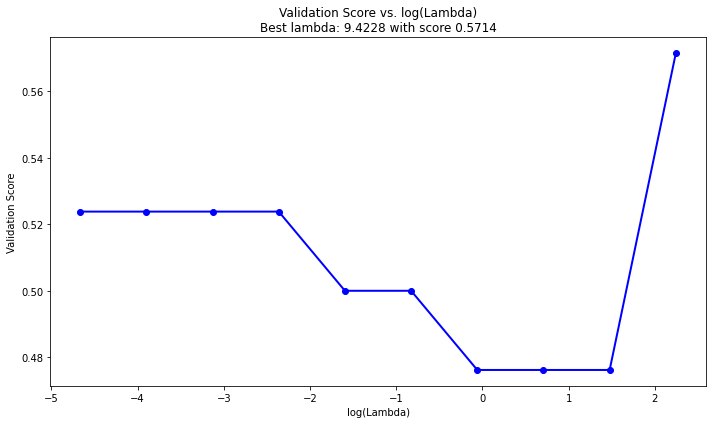

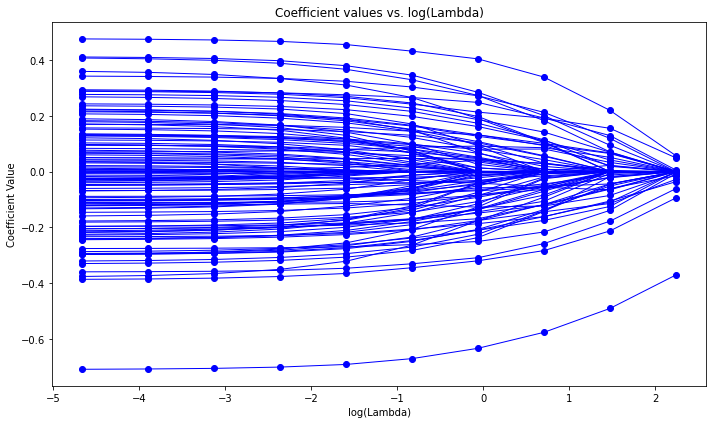

In [47]:
logRegCCD.plot_score()
logRegCCD.plot_coeff()

## dataset3

In [55]:
isolet_data = pd.read_csv("data/isolet.csv", header=None)

isolet_X = isolet_data.iloc[:, :-1]
isolet_y = (isolet_data.iloc[:, -1] == 2).astype(int)
print(isolet_X.shape)
print(isolet_X.columns)
print("Target distribution:", sum(isolet_y) / len(isolet_y))
print(isolet_X.head())

isolet_X_train, isolet_X_valid, isolet_y_train, isolet_y_valid = train_test_split(
    isolet_X, isolet_y, test_size=0.2, random_state=42, stratify=isolet_y
)

(600, 617)
Index([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,
       ...
       607, 608, 609, 610, 611, 612, 613, 614, 615, 616],
      dtype='int64', length=617)
Target distribution: 0.5
      0       1       2       3       4       5       6       7       8    \
0 -0.4394 -0.0930  0.1718  0.4620  0.6226  0.4704  0.3578  0.0478 -0.1184   
1 -0.4348 -0.1198  0.2474  0.4036  0.5026  0.6328  0.4948  0.0338 -0.0520   
2 -0.2330  0.2124  0.5014  0.5222 -0.3422 -0.5840 -0.7168 -0.6342 -0.8614   
3 -0.3808 -0.0096  0.2602  0.2554 -0.4290 -0.6746 -0.6868 -0.6650 -0.8410   
4  0.0362  0.7510  0.7188  1.0000  0.9358  0.9840  0.8072  0.4338  0.2290   

      9    ...     607     608     609     610     611     612     613  \
0 -0.2310  ...  0.3334  0.4102  0.2052  0.3846  0.3590  0.5898  0.3334   
1 -0.1302  ...  0.2272  0.0000  0.2954  0.2046  0.4772  0.0454  0.2046   
2 -0.8318  ...  0.0952 -0.1112 -0.0476 -0.1746  0.0318 -0.0476  0.1112   
3 -0.9614  ...  0.0648 -0.0504 -0.0360 -0.1224

In [56]:
# lambda = 0
logRegCCD_0 = LogRegCCD()
logRegCCD_0 = logRegCCD_0.single_fit(isolet_X_train, isolet_y_train, lambda_ = 0)
evaluate_performance(logRegCCD_0, isolet_X_valid, isolet_y_valid)


Accuracy score:  0.49166666666666664
Precision score:  0.4918032786885246
Recall score:  0.5
F-measure score:  0.49586776859504134
Balanced Accuracy score:  0.4916666666666667
AUC-ROC score:  0.4916666666666666
AUC-PR: score:  0.4959016393442623


Accuracy score:  0.5
Precision score:  0.0
Recall score:  0.0
F-measure score:  0.0
Balanced Accuracy score:  0.5
AUC-ROC score:  0.5
AUC-PR: score:  0.5


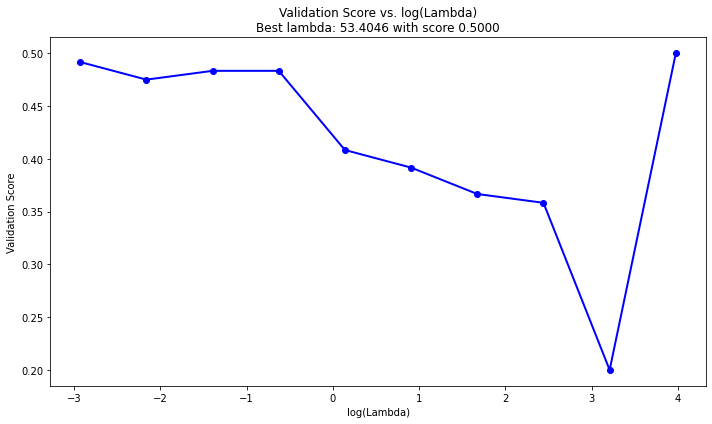

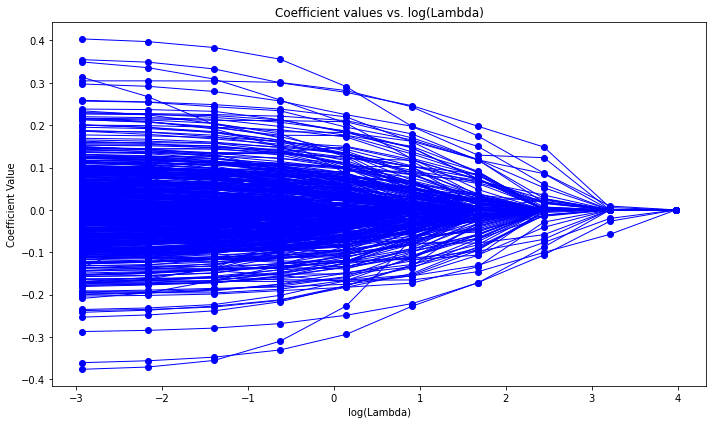

In [57]:
logRegCCD = LogRegCCD()
logRegCCD = logRegCCD.fit(isolet_X_train, isolet_y_train, isolet_X_valid, isolet_y_valid)

evaluate_performance(logRegCCD, isolet_X_valid, isolet_y_valid)
logRegCCD.plot_score()
logRegCCD.plot_coeff()

## dataset4

In [77]:
bio_data = pd.read_csv("data/bio.csv", header=None, skiprows=1)

print(bio_data.shape)

bio_X = bio_data.iloc[:, :-1]
bio_y = bio_data.iloc[:, -1]


print(bio_X.shape)
print("Target distribution:", sum(bio_y) / len(bio_y))
print(bio_X.head())

bio_X_train, bio_X_valid, bio_y_train, bio_y_valid = train_test_split(
    bio_X, bio_y, test_size=0.2, random_state=42, stratify=bio_y
)

(3751, 1777)
(3751, 1776)
Target distribution: 0.5422553985603839
       0         1     2     3         4         5         6         7     \
0  0.000000  0.497009  0.10   0.0  0.132956  0.678031  0.273166  0.585445   
1  0.366667  0.606291  0.05   0.0  0.111209  0.803455  0.106105  0.411754   
2  0.033300  0.480124  0.00   0.0  0.209791  0.610350  0.356453  0.517720   
3  0.000000  0.538825  0.00   0.5  0.196344  0.724230  0.235606  0.288764   
4  0.100000  0.517794  0.00   0.0  0.494734  0.781422  0.154361  0.303809   

       8         9     ...  1766  1767  1768  1769  1770  1771  1772  1773  \
0  0.743663  0.243144  ...   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
1  0.836582  0.106480  ...   1.0   1.0   1.0   1.0   0.0   1.0   0.0   0.0   
2  0.679051  0.352308  ...   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
3  0.805110  0.208989  ...   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
4  0.812646  0.125177  ...   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   

  

In [78]:
# lambda = 0
logRegCCD_0 = LogRegCCD()
logRegCCD_0 = logRegCCD_0.single_fit(bio_X_train, bio_y_train, lambda_ = 0)
evaluate_performance(logRegCCD_0, bio_X_valid, bio_y_valid)


Accuracy score:  0.49134487350199735
Precision score:  0.5322997416020672
Recall score:  0.5061425061425061
F-measure score:  0.5188916876574308
Balanced Accuracy score:  0.4899898577224159
AUC-ROC score:  0.4899898577224158
AUC-PR: score:  0.5370626677101764


In [ ]:
logRegCCD = LogRegCCD()
logRegCCD = logRegCCD.fit(bio_X_train, bio_y_train, bio_X_valid, bio_y_valid)

evaluate_performance(logRegCCD, bio_X_valid, bio_y_valid)
logRegCCD.plot_score()
logRegCCD.plot_coeff()

In [64]:
hiva_data = pd.read_csv("data/hiva.csv", header=None)

hiva_X = hiva_data.iloc[:, :-1]
hiva_y = hiva_data.iloc[:, -1]


print(hiva_y)
hiva_y = (hiva_y==1).astype(int)
print(hiva_y)


print(hiva_X.shape)
print("Target distribution (1 as 1, -1 as 0):", sum(hiva_y) / len(hiva_y))
print(hiva_X.head())

hiva_X_train, hiva_X_valid, hiva_y_train, hiva_y_valid = train_test_split(
    hiva_X, hiva_y, test_size=0.2, random_state=42, stratify=hiva_y
)

0      False
1      False
2      False
3      False
4      False
       ...  
640    False
641    False
642    False
643    False
644    False
Name: 278, Length: 645, dtype: bool
0      0
1      0
2      0
3      0
4      0
      ..
640    0
641    0
642    0
643    0
644    0
Name: 278, Length: 645, dtype: int32
(4230, 1617)
Target distribution (1 as 1, -1 as 0): 0.040310077519379844
    0      1      2      3      4      5      6      7      8      9     ...  \
0  attr0  attr1  attr2  attr3  attr4  attr5  attr6  attr7  attr8  attr9  ...   
1    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0  ...   
2    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0  ...   
3    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0  ...   
4    0.0    0.0    0.0    0.0    0.0    0.0    0.0    1.0    0.0    0.0  ...   

       1607      1608      1609      1610      1611      1612      1613  \
0  attr1607  attr1608  attr1609  attr1610  attr1611  att

ValueError: Found input variables with inconsistent numbers of samples: [4230, 645]

In [ ]:
# lambda = 0
logRegCCD_0 = LogRegCCD()
logRegCCD_0 = logRegCCD_0.single_fit(hiva_X_train, hiva_y_train, lambda_ = 0)
evaluate_performance(logRegCCD_0, hiva_X_valid, hiva_y_valid)


In [ ]:
logRegCCD = LogRegCCD()
logRegCCD = logRegCCD.fit(hiva_X_train, hiva_y_train, hiva_X_valid, hiva_y_valid)

evaluate_performance(logRegCCD, hiva_X_valid, hiva_y_valid)
logRegCCD.plot_score()
logRegCCD.plot_coeff()

## Synthetic dataset

In [5]:
def generate_synthetic_data(p, n, d, g, seed=42):
    """
    Generate a synthetic dataset based on the given parameters.
    
    Parameters
    ----------
        p: float
            Prior probability for class Y=1.
        n: int
            Number of observations.
        d:  int
            Dimensionality of feature space.
        g: float 
            Covariance decay factor.
    
    Returns
    ----------
        DataFrame: A DataFrame containing generated features and class labels.
    """
    np.random.seed(seed)
    # Generate binry class variable
    y = np.random.binomial(1, p, size=n)

    # Define means for multivariate normal distribution
    mean_0 = np.zeros(d)
    mean_1 = np.array([1 / (i + 1) for i in range(d)])

    # Define covariance matrix S
    indices = np.arange(d)
    S = np.array([[g ** np.abs(i - j) for j in indices] for i in indices])
    
    # Create DataFrame
    X = np.array([
        np.random.multivariate_normal(mean_1 if y_id == 1 else mean_0, S)
        for y_id in y
    ])
    columns = [f'X{i+1}' for i in range(d)]
    X = pd.DataFrame(X, columns=columns)
    
    return X, y


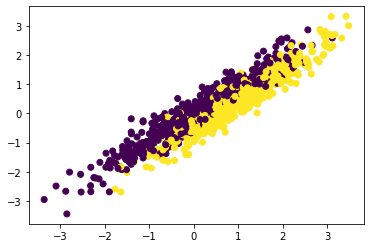

In [33]:
np.random.seed(42)
p = 0.5
n = 1000
d = 12
g = 0.95

synthetic_X, synthetic_y = generate_synthetic_data(p, n, d, g)
plt.scatter(synthetic_X["X1"], synthetic_X["X2"], c=synthetic_y)
plt.show()

Accuracy score:  0.86
Precision score:  0.8817204301075269
Recall score:  0.8282828282828283
F-measure score:  0.8541666666666666
Balanced Accuracy score:  0.8596859685968596
AUC-ROC score:  0.8596859685968598
AUC-PR: score:  0.8153138916042142


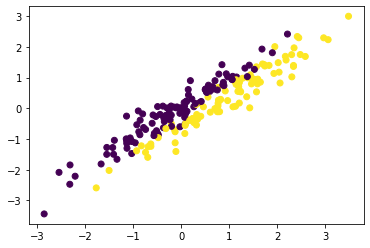

In [34]:
synthetic_X_train, synthetic_X_valid, synthetic_y_train, synthetic_y_valid = train_test_split(
    synthetic_X, synthetic_y, test_size=0.2, random_state=42, stratify=synthetic_y
)

logRegCCD = LogRegCCD()
logRegCCD = logRegCCD.fit(synthetic_X_train, synthetic_y_train, synthetic_X_valid, synthetic_y_valid)
# Get predicted probabilities
y_prob_syn = logRegCCD.predict_proba(synthetic_X_valid)

evaluate_performance(logRegCCD, synthetic_X_valid, synthetic_y_valid)

y_pred_syn = (y_prob_syn >= 0.5).astype(int)
plt.scatter(synthetic_X_valid.iloc[:,0], synthetic_X_valid.iloc[:,1], c=y_pred_syn)
plt.show()

Accuracy:  0.865
Beta:  [[ 5.45494591 -3.01156683 -0.8311785  -0.68824977  0.28341473 -0.74656479
   0.0116524  -0.13038484  0.56853299 -0.69770672  0.44874621 -0.04830193]]
Beta zero:  [-1.87057333]


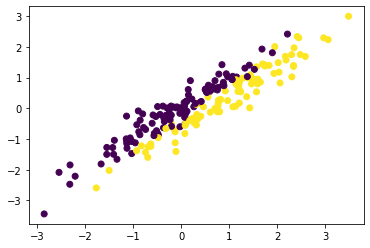

In [35]:
clf = LogisticRegression(random_state=42, penalty='none').fit(synthetic_X_train, synthetic_y_train)
print("Accuracy: ", clf.score(synthetic_X_valid, synthetic_y_valid))

print("Beta: ", clf.coef_)
print("Beta zero: ", clf.intercept_)
y_pred_lg = clf.predict(synthetic_X_valid)
plt.scatter(synthetic_X_valid.iloc[:,0], synthetic_X_valid.iloc[:,1], c=y_pred_lg)
plt.show()

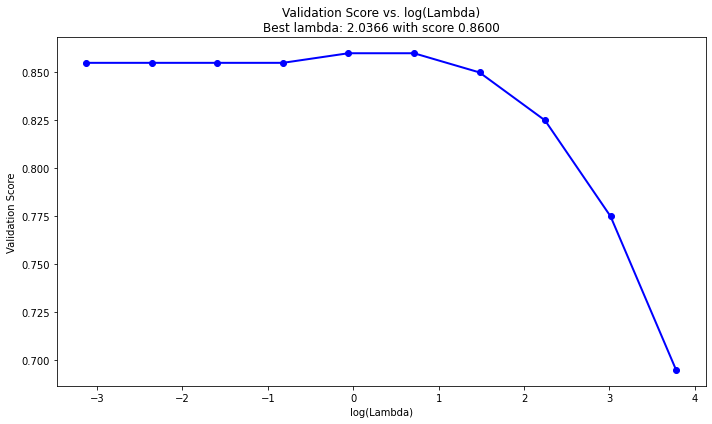

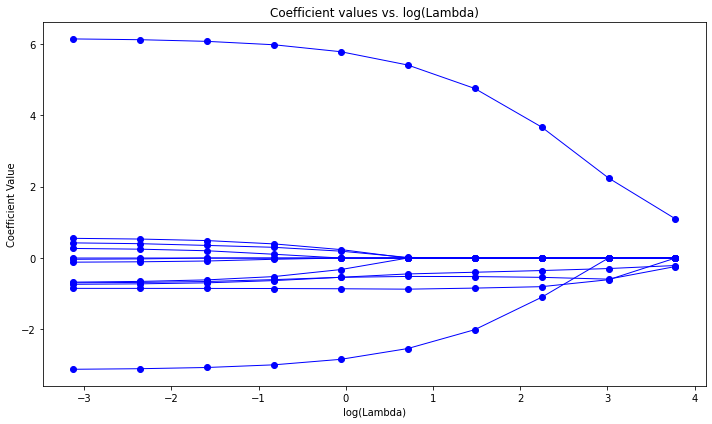

In [36]:
logRegCCD.plot_score()
logRegCCD.plot_coeff()

## predict_students_dropout_and_academic_success

In [37]:
student_dropout_X = pd.read_csv("./data/predict_students_dropout_and_academic_success/data.csv", sep=";")
student_dropout_y = (student_dropout_X['Target'] == 'Graduate').astype(int)
student_dropout_X.drop("Target", inplace=True, axis=1)
print(student_dropout_X.shape)
print("Graduated: ", sum(student_dropout_y)/len(student_dropout_y))
student_dropout_X.head()

(4424, 36)
Graduated:  0.4993218806509946


,Marital status,Application mode,Application order,Course,Daytime/evening attendance\t,Previous qualification,Previous qualification (grade),Nacionality,Mother's qualification,Father's qualification,...,Curricular units 1st sem (without evaluations),Curricular units 2nd sem (credited),Curricular units 2nd sem (enrolled),Curricular units 2nd sem (evaluations),Curricular units 2nd sem (approved),Curricular units 2nd sem (grade),Curricular units 2nd sem (without evaluations),Unemployment rate,Inflation rate,GDP
0,1,17,5,171,1,1,122.0,1,19,12,...,0,0,0,0,0,0.000000,0,10.8,1.4,1.74
1,1,15,1,9254,1,1,160.0,1,1,3,...,0,0,6,6,6,13.666667,0,13.9,-0.3,0.79
2,1,1,5,9070,1,1,122.0,1,37,37,...,0,0,6,0,0,0.000000,0,10.8,1.4,1.74
3,1,17,2,9773,1,1,122.0,1,38,37,...,0,0,6,10,5,12.400000,0,9.4,-0.8,-3.12
4,2,39,1,8014,0,1,100.0,1,37,38,...,0,0,6,6,6,13.000000,0,13.9,-0.3,0.79


In [38]:
student_dropout_X_train, student_dropout_X_valid, student_dropout_y_train, student_dropout_y_valid = train_test_split(
    student_dropout_X, student_dropout_y, test_size=0.2, random_state=42, stratify=student_dropout_y
)


logRegCCD = LogRegCCD()
logRegCCD = logRegCCD.fit(student_dropout_X_train, student_dropout_y_train, student_dropout_X_valid, student_dropout_y_valid)

evaluate_performance(logRegCCD, student_dropout_X_valid, student_dropout_y_valid)

Accuracy score:  0.4994350282485876
Precision score:  0.4994350282485876
Recall score:  1.0
F-measure score:  0.666164280331575
Balanced Accuracy score:  0.5
AUC-ROC score:  0.5
AUC-PR: score:  0.4994350282485876


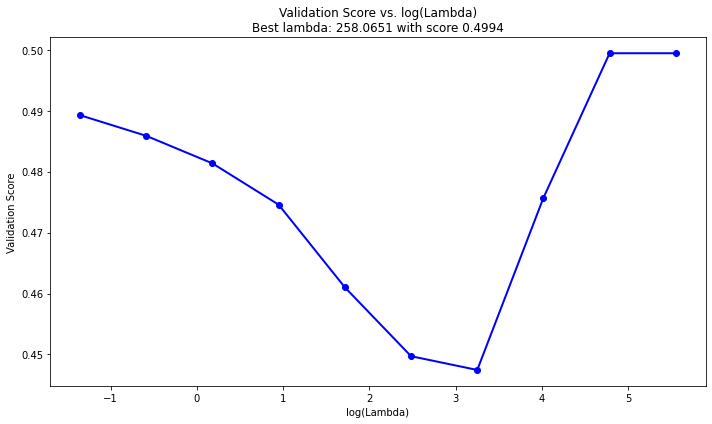

(258.06508247749036, 0.4994350282485876)

In [39]:
logRegCCD.plot_score()

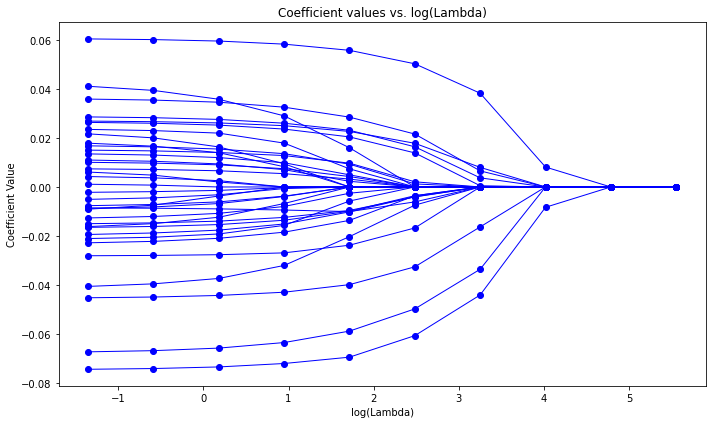

In [40]:
logRegCCD.plot_coeff()

In [41]:
clf = LogisticRegression(random_state=42, penalty='none').fit(student_dropout_X_train, student_dropout_y_train)
print("Accuracy: ", clf.score(student_dropout_X_valid, student_dropout_y_valid))

print("Beta: ", clf.coef_)
print("Beta zero: ", clf.intercept_)

Accuracy:  0.7932203389830509
Beta:  [[ 3.12327791e-03 -7.03848191e-03  5.03734969e-03 -6.43675255e-04
  -4.68897280e-03 -2.51275341e-02  6.15675957e-03 -7.52487409e-03
   1.39726702e-02 -3.61355045e-03  8.32725292e-03 -1.01337202e-02
  -3.55404014e-03 -8.92229495e-04 -1.99160431e-04 -1.41990182e-02
   1.74116145e-02 -1.68868116e-02  2.30955418e-02 -5.09298785e-02
   3.76157303e-04 -2.97439299e-03  2.22025242e-02 -8.24716858e-02
   1.99368153e-01  2.08400433e-01 -8.35708610e-03 -9.68017597e-04
   2.21275916e-02 -8.67312770e-02  2.47674458e-01  2.81738651e-01
  -1.28717739e-02  1.89901822e-03 -5.34575214e-03  1.15372288e-02]]
Beta zero:  [-0.00170737]
